# Network Science Assignment 2 Bonus Part : Top-Leaders - Group 10

Submitted by Venkatesh Ramesh, Julia Kaltenborn and Yiran Wang

Deadline: Monday, 4th of October, 2021

This notebook is for the implementation of Top-Leaders Algorithm

# Top Leaders Algorithm

We implement Top-Leaders algorithm with a small amendment. Instead of using the initialization suggested in paper, we use random initialization. In paper, authors suggested using k most central nodes that are not connected to each other as k leaders initialization, however, in practice, we found that this kind of initialization will separate groups. The algorithm barely updates leaders after initialization. We think this is due to the hyperparameters selection (gamma, delta). We stick to the random initialization since it already give us good clustering compared to algorithms we used in task2.

In [1]:
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from cdlib import algorithms, NodeClustering
from collections import OrderedDict

In [2]:
#DATA_DIR = '/Users/Venky/Documents/Fall2021/Network Science/NS_assignment_2/'
DATA_DIR = './'

# mail dataset
EMAIL_DIR = DATA_DIR + 'email-Enron/'
EMAIL_FILE = os.path.join(EMAIL_DIR, 'email-Enron.txt')
NAME_FILE = os.path.join(EMAIL_DIR, 'addresses-email-Enron.txt') 

# real-classic datasets
STRIKE_DIR = DATA_DIR + 'real-classic/strike.gml'
KARATE_DIR = DATA_DIR + 'real-classic/karate.gml'
POLBLOGS_DIR = DATA_DIR + 'real-classic/polblogs.gml'
POLBOOKS_DIR = DATA_DIR + 'real-classic/polbooks.gml'
FOOTBALL_DIR = DATA_DIR + 'real-classic/football.gml'

# real-node datasets
#CITESEER_DIR = DATA_DIR +
#CORA_DIR = DATA_DIR +
#PUBMED_DIR = DATA_DIR +

# get the lfr directly from networkx (done in the init method)
LFR_Graph = "LFR"

In [3]:
# add multigraph description in football and polblogs dataset
first_time = True

if first_time:
    with open(POLBLOGS_DIR, "r") as f:
        contents = f.readlines()

    contents.insert(3, "  multigraph 1\n")

    with open(DATA_DIR + 'real-classic/polblogs.gml', "w") as f:
        contents = "".join(contents)
        f.write(contents)

    # repeat for football dataset
    with open(FOOTBALL_DIR, "r") as f:
        contents = f.readlines()

    contents.insert(3, "  multigraph 1\n")

    with open(DATA_DIR + 'real-classic/football.gml', "w") as f:
        contents = "".join(contents)
        f.write(contents)


In [200]:
# TODO convert to unweighted graph as well!
# TODO do I need to change something for multigraphs?
import random
import copy
from collections import Counter, defaultdict
from cdlib import NodeClustering
from cdlib.utils import (
    convert_graph_formats,
    __from_nx_to_graph_tool,
    affiliations2nodesets,
    nx_node_integer_mapping,
)

class GraphClustering:
    
    def __init__(self, path):
        '''Loading the desired graph.
        Parameters:
            path (str): Path to dataset with '.gml' extension that stores nodes and edges, or 'LFR' for synthetic dataset
        '''
        if path == 'LFR': 
            self.graph = nx.generators.community.LFR_benchmark_graph
        elif path.split('.')[-1] == 'gml':
            self.graph = nx.read_gml(path)
            
        # convert nodes to integers
        if not isinstance(list(self.graph.nodes.data())[0][0], int):
            self.graph = nx.relabel.convert_node_labels_to_integers(self.graph, first_label=1)
            
        # list of clusters sorted according to nodes ids
        self.pred_clusters = None
        # convert clusters to integers
        if not isinstance(list(self.graph.nodes.data())[0][1]['value'], int):
            clusters = list(set([node[1]['value'] for node in self.graph.nodes.data()]))
            self.true_clusters = [clusters.index(node[1]['value']) for node in self.graph.nodes.data()]
        else:
            self.true_clusters = [node[1]['value']-1 for node in self.graph.nodes.data()]
        
        # create community list necessary for community init
        com_list = [[] for cluster_set in set(self.true_clusters)]
        for node, cluster in enumerate(self.true_clusters):
            com_list[cluster].append(node + 1)
        # community objects
        self.pred_communities = None
        self.true_communities = NodeClustering(communities=com_list, graph=self.graph, method_name="ground_truth")
        
        # store position of graph and name of the currently used clustering algorithm
        self.alg = ""
        self.graph_pos = nx.spring_layout(self.graph, seed = 42)
        
        print('Loaded Graph')
        
    def draw_clusters(self, which='true', dataset_name=''):
        '''
        Parameters:
            which (str): 'true' or 'pred'
            dataset_name (str): Name of dataset printed in title
        '''
        # get all the values of the graph
        #colors = [node[1]['value'] for node in self.graph.nodes.data()]
        if which == 'true':
            nx.draw(self.graph, node_color=self.true_clusters, cmap='tab10', pos=self.graph_pos)
            plt.title('True Graph Clustering of Dataset {}'.format(dataset_name))
        elif which == 'pred':
            nx.draw(self.graph, node_color=self.pred_clusters, cmap='tab10', pos=self.graph_pos)
            plt.title('Predicted Graph Clustering of Dataset {} with {}'.format(dataset_name, self.alg))
        else:
            print("You must either choose 'true' or 'pred'")
            
        plt.show()
        
    def communities_to_list(self, communities):
        '''
        '''
        node_cluster_dict = {int(node): cluster[0] for node, cluster in communities.to_node_community_map().items()}
        ordered_node_cluster_list = list(OrderedDict(sorted(node_cluster_dict.items())).values())
        return ordered_node_cluster_list
        
        
    def infomap_clustering(self):
        ''' infomap clustering
        '''
        self.alg = 'infomap'
        self.pred_communities = algorithms.infomap(self.graph)
        self.pred_clusters = self.communities_to_list(self.pred_communities)
        
    def lovain_clustering(self):
        ''' lovain clustering
        '''
        self.alg = 'lovain'
        # convert graph to undirected for lovain clustering
        clean_graph = self.graph
        if self.graph.is_directed():
            clean_graph = clean_graph.to_undirected()
            
        self.pred_communities = algorithms.louvain(clean_graph)
        self.pred_clusters = self.communities_to_list(self.pred_communities)
        
    def label_propagation_clustering(self):
        ''' label propagation clustering
        '''
        self.alg = 'label_propagation'
        # convert graph to undirected for label propagation
        clean_graph = self.graph
        if self.graph.is_directed():
            clean_graph = clean_graph.to_undirected()
        
        self.pred_communities = algorithms.label_propagation(clean_graph)
        self.pred_clusters = self.communities_to_list(self.pred_communities)
    
    def eigenvector_clustering(self):
        ''' eigenvector clustering
        '''
        self.alg = 'eigenvector'
        # convert graph to undirected for eigenvector clustering
        clean_graph = self.graph
        if self.graph.is_directed():
            clean_graph = clean_graph.to_undirected()
            
        self.pred_communities = algorithms.eigenvector(clean_graph)
        self.pred_clusters = self.communities_to_list(self.pred_communities)
    
    def walktrap_clustering(self):
        ''' walktrap clustering
        '''
        self.alg = 'walktrap'
        # convert graph to undirected for walktrap clustering
        clean_graph = self.graph
        if self.graph.is_directed():
            clean_graph = clean_graph.to_undirected()
            
        self.pred_communities = algorithms.walktrap(clean_graph)
        self.pred_clusters = self.communities_to_list(self.pred_communities)
        
    def calc_modularity(self):
        ''' Returns Q modularity
        '''
        return self.pred_communities.newman_girvan_modularity().score
    
    def ari(self):
        ''' Returns adjusted rand index score
        '''
        return self.true_communities.adjusted_rand_index(self.pred_communities).score
    
    def nmi(self):
        ''' Return normalized mutual information score
        '''
        return self.true_communities.normalized_mutual_information(self.pred_communities).score
    
    def compare_algs(self, show_graph=False, clustering_algs=['walktrap_clustering'], dataset_name=''):
        ''' Comparing the different algorithms on the current graph
        
        Parameters:
            show_graph (bool): if the graphs with colored clusters should be printed
            clustering_algs (list): list with clustering algorithms that should be applied
            dataset_name (str): name of the dataset on which the algs are run
        
        Returns:
            dict <3-tuple>: A dictionary with the algs as keys and the results as values. 
                Each value is n-tuple, where the 1st entry is modularity, the 2nd ari and the 3rd nmi
        '''
        results = {}

        for func in clustering_algs:
            getattr(self, func)()
            results[str(func)] = (self.calc_modularity(), self.ari(), self.nmi())
            if show_graph:
                strike.draw_clusters(dataset_name=dataset_name, which='pred')
                
        return results
    
    
    '''
    The following method are for Top-Leaders algorithm
    '''
    
    def intersection(self, lst1, lst2):
        lst3 = [value for value in lst1 if value in lst2]
        return lst3
    
    def centrality_propagation(self, horizon=1, gamma=1):
        if self.graph.is_directed():
            G = self.graph.to_undirected()
        else:
            G = self.graph
        
        G = nx.Graph(G)
#         G = self.graph
            
        g = convert_graph_formats(G, nx.Graph)
        
        coms = list(self.centrality_propagation_communities(g, horizon, gamma))
        coms = [list(x) for x in coms]

        self.pred_communities = NodeClustering(
            coms, g, "Centrality Propagation", method_parameters={"": ""}
        )
        
        self.pred_clusters = self.communities_to_list(self.pred_communities)
    
    def centrality_propagation_communities(self, G, horizon=1, gamma=1):
        centralities = nx.algorithms.centrality.degree_centrality(G)
        
        coloring = self._color_network(G)
        # Create a unique label for each node in the graph
        labeling = {v: k for k, v in enumerate(G)}
        while not self._labeling_complete(labeling, centralities, G, horizon, gamma):
            # Update the labels of every node with the same color.
            for color, nodes in coloring.items():
                for n in nodes:
                    self._update_label(n, labeling, centralities, G, horizon, gamma)

        clusters = defaultdict(set)
        for node, label in labeling.items():
            clusters[label].add(node)
        return clusters.values()


    def _color_network(self, G):
        """Colors the network so that neighboring nodes all have distinct colors.
        Returns a dict keyed by color to a set of nodes with that color.
        """
        coloring = dict()  # color => set(node)
        colors = nx.coloring.greedy_color(G)
        for node, color in colors.items():
            if color in coloring:
                coloring[color].add(node)
            else:
                coloring[color] = {node}
        return coloring


    def _labeling_complete(self, labeling, centralities, G, horizon=1, gamma=1):
        """Determines whether or not LPA is done.
        Label propagation is complete when all nodes have a label that is
        in the set of highest frequency labels amongst its neighbors.
        Nodes with no neighbors are considered complete.
        """
        return all(
            labeling[v] in self._most_frequent_labels(v, labeling, centralities, G, horizon, gamma) for v in G if len(G[v]) > 0
        )


    def _most_frequent_labels(self, node, labeling, centralities, G, horizon=1, gamma=1):
        """Returns a set of all labels with maximum frequency in `labeling`.
        Input `labeling` should be a dict keyed by node to labels.
        """
        if not G[node]:
            # Nodes with no neighbors are themselves a community and are labeled
            # accordingly, hence the immediate if statement.
            return {labeling[node]}

        # Compute the frequencies of all neighbours of node
        # keys are int (nodes number)
#         freqs = Counter(labeling[q] for q in G[node])
        freqs = {}
#         for q in G[node]:
#             label = labeling[q]
#             centrality = centralities[q]
#             if label not in freqs:
#                 freqs[label] = centrality
#             else:
#                 freqs[label] += centrality
        freqs[labeling[node]] = centralities[node]

        while horizon > 0:
            if horizon > 1:
                larger_neighbourhood = list(nx.ego_graph(G, node, radius=horizon, center=False))
                smaller_neighbourhood = list(nx.ego_graph(G, node, radius=horizon-1, center=False))
                neighbours_with_distance_k = self.gap(larger_neighbourhood, smaller_neighbourhood)
            else:
                neighbourhood = list(nx.ego_graph(self.graph, node, radius=horizon, center=False))
                neighbours_with_distance_k = neighbourhood
            
            for neighbour in neighbours_with_distance_k:
                index = neighbour # index starts from 0 and node starts from 1
                label = labeling[index]
                centrality_prop = gamma ** (horizon - 1) * centralities[neighbour]
#                 print(centrality_prop)
                if label not in freqs:
                    freqs[label] = centrality_prop
                else:
                    freqs[label] += centrality_prop
                    
            horizon -= 1
            
        
        max_freq = max(freqs.values())
        return {label for label, freq in freqs.items() if freq == max_freq}


    def _update_label(self, node, labeling, centralities, G, horizon=1, gamma=1):
        """Updates the label of a node using the Prec-Max tie breaking algorithm
        The algorithm is explained in: 'Community Detection via Semi-Synchronous
        Label Propagation Algorithms' Cordasco and Gargano, 2011
        """
        high_labels = self._most_frequent_labels(node, labeling, centralities, G, horizon, gamma)
        if len(high_labels) == 1:
            labeling[node] = high_labels.pop()
        elif len(high_labels) > 1:
            # Prec-Max
            if labeling[node] not in high_labels:
                labeling[node] = max(high_labels)
    
    def gap(self, lst1, lst2):
        # lst1 should be larger than lst2
        # make sure of this before finding the gap between two list
        for value in lst2:
            assert value in lst1
        
        lst3 = [value for value in lst1 if value not in lst2]
        
        return lst3
                

Loaded Graph
0.5331910534342316


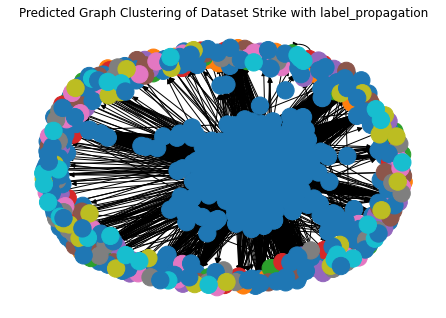

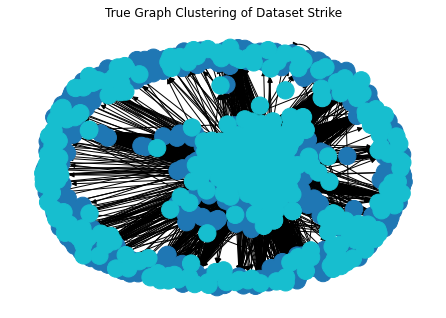

In [196]:
STRIKE_DIR = DATA_DIR + 'real-classic/strike.gml'
KARATE_DIR = DATA_DIR + 'real-classic/karate.gml'
POLBLOGS_DIR = DATA_DIR + 'real-classic/polblogs.gml'
POLBOOKS_DIR = DATA_DIR + 'real-classic/polbooks.gml'
FOOTBALL_DIR = DATA_DIR + 'real-classic/football.gml'

strike = GraphClustering(POLBLOGS_DIR)
strike.label_propagation_clustering()
print(strike.ari())
strike.draw_clusters(dataset_name="Strike", which='pred')
strike.draw_clusters(dataset_name="Strike", which='true')

In [201]:
STRIKE_DIR = DATA_DIR + 'real-classic/strike.gml'
KARATE_DIR = DATA_DIR + 'real-classic/karate.gml'
POLBLOGS_DIR = DATA_DIR + 'real-classic/polblogs.gml'
POLBOOKS_DIR = DATA_DIR + 'real-classic/polbooks.gml'
FOOTBALL_DIR = DATA_DIR + 'real-classic/football.gml'

strike = GraphClustering(POLBLOGS_DIR)
strike.centrality_propagation(horizon=1, gamma=1.5)
print(strike.ari())
strike.draw_clusters(dataset_name="polblogs", which='pred')
# strike.draw_clusters(dataset_name="polbooks", which='true')

Loaded Graph


KeyboardInterrupt: 

Loaded Graph


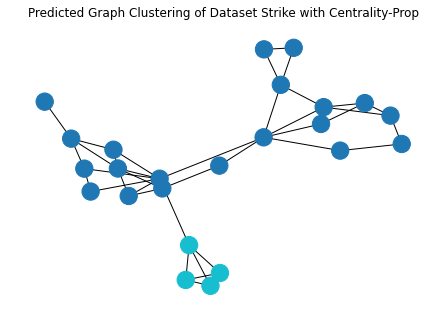

0.36224442162263093


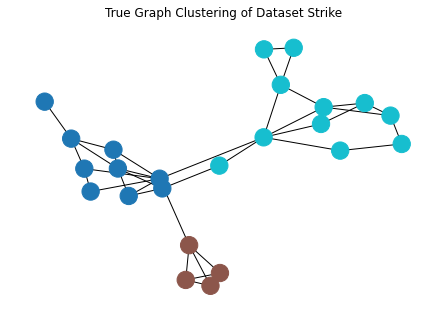

In [167]:
STRIKE_DIR = DATA_DIR + 'real-classic/strike.gml'
KARATE_DIR = DATA_DIR + 'real-classic/karate.gml'
POLBLOGS_DIR = DATA_DIR + 'real-classic/polblogs.gml'
POLBOOKS_DIR = DATA_DIR + 'real-classic/polbooks.gml'
FOOTBALL_DIR = DATA_DIR + 'real-classic/football.gml'

strike = GraphClustering(STRIKE_DIR)
strike.centrality_propogation(horizon=2, gamma=0.01, max_steps=50)
strike.draw_clusters(dataset_name="Strike", which='pred')
print(strike.ari())

strike.draw_clusters(dataset_name="Strike", which='true')

In [15]:
def construct_community(label_list):
    # index + 1 of the list is the id of the node
    # value at that index is the label of the node
    community_list = {} # keep track of the appearing community
    cluster_list = [] # actual cluster list (list of list)
    for node, label in enumerate(label_list):
        node = node + 1 # get the true node
        if label not in community_list:
            community_list[label] = len(cluster_list) # value of the community_list is the index of the cluster_list
            cluster_list.append([])
        cluster_list[community_list[label]].append(node)

    return cluster_list


label_list = [1, 1, 4, 2, 4, 5, 10]
construct_community(label_list)

[[1, 2], [3, 5], [4], [6], [7]]

In [17]:
list(strike.graph.nodes())

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24]

In [10]:
for node in strike.graph:
    print(node)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


In [5]:
strike = GraphClustering(STRIKE_DIR)
strike.label_propagation_clustering()
strike.pred_communities

Loaded Graph


In [13]:
dir(strike.pred_communities)

['_Clustering__convert_back_to_original_nodes_names_if_needed',
 '_NodeClustering__check_graph',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'adjusted_mutual_information',
 'adjusted_rand_index',
 'average_internal_degree',
 'avg_distance',
 'avg_embeddedness',
 'avg_odf',
 'avg_transitivity',
 'communities',
 'conductance',
 'cut_ratio',
 'edges_inside',
 'erdos_renyi_modularity',
 'expansion',
 'f1',
 'flake_odf',
 'fraction_over_median_degree',
 'get_description',
 'graph',
 'hub_dominance',
 'internal_edge_density',
 'link_modularity',
 'max_odf',
 'method_name',
 'method_parameters',
 'modularity_density',
 'modularity_overlap',
 'newman_girvan_modularity',
 '

Loaded Graph
{1: 0.043478260869565216, 2: 0.17391304347826086, 3: 0.13043478260869565, 4: 0.08695652173913043, 5: 0.13043478260869565, 6: 0.21739130434782608, 7: 0.13043478260869565, 8: 0.13043478260869565, 9: 0.30434782608695654, 10: 0.17391304347826086, 11: 0.13043478260869565, 12: 0.13043478260869565, 13: 0.13043478260869565, 14: 0.2608695652173913, 15: 0.08695652173913043, 16: 0.08695652173913043, 17: 0.08695652173913043, 18: 0.13043478260869565, 19: 0.17391304347826086, 20: 0.13043478260869565, 21: 0.08695652173913043, 22: 0.17391304347826086, 23: 0.08695652173913043, 24: 0.08695652173913043}
[10, 9, 14]
[10, 9, 14]


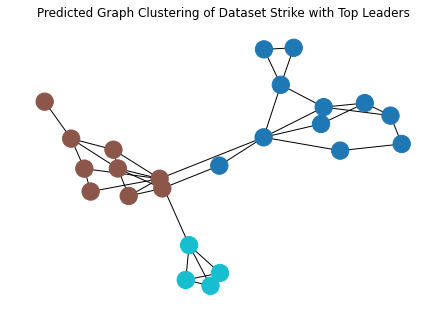

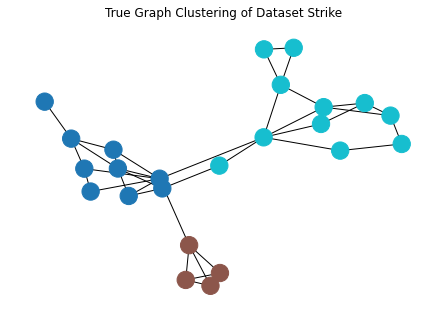

In [135]:
strike = GraphClustering(STRIKE_DIR)
strike.top_leaders(k=3, gamma=0, delta=2)
strike.draw_clusters(dataset_name="Strike", which='pred')

strike.draw_clusters(dataset_name="Strike", which='true')

Loaded Graph
{1: 0.10526315789473684, 2: 0.10526315789473684, 3: 0.10526315789473684, 4: 0.11403508771929824, 5: 0.09649122807017543, 6: 0.10526315789473684, 7: 0.10526315789473684, 8: 0.10526315789473684, 9: 0.09649122807017543, 10: 0.09649122807017543, 11: 0.08771929824561403, 12: 0.08771929824561403, 13: 0.08771929824561403, 14: 0.09649122807017543, 15: 0.09649122807017543, 16: 0.10526315789473684, 17: 0.09649122807017543, 18: 0.09649122807017543, 19: 0.09649122807017543, 20: 0.09649122807017543, 21: 0.09649122807017543, 22: 0.09649122807017543, 23: 0.09649122807017543, 24: 0.09649122807017543, 25: 0.08771929824561403, 26: 0.09649122807017543, 27: 0.08771929824561403, 28: 0.09649122807017543, 29: 0.07894736842105263, 30: 0.09649122807017543, 31: 0.09649122807017543, 32: 0.09649122807017543, 33: 0.09649122807017543, 34: 0.08771929824561403, 35: 0.09649122807017543, 36: 0.09649122807017543, 37: 0.07017543859649122, 38: 0.09649122807017543, 39: 0.09649122807017543, 40: 0.09649122807017

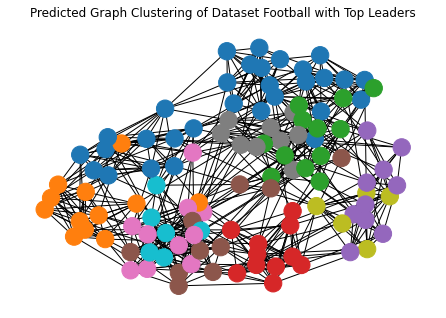

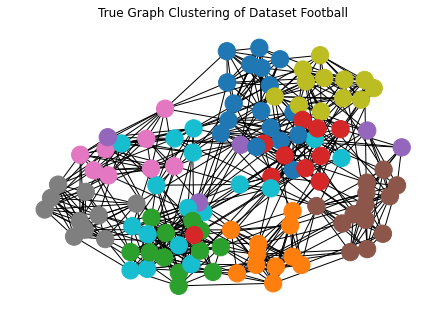

In [140]:
footballl = GraphClustering(FOOTBALL_DIR)
footballl.top_leaders(k=11, gamma=1, delta=2)
footballl.draw_clusters(dataset_name="Football", which='pred')

footballl.draw_clusters(dataset_name="Football", which='true')

Loaded Graph
{1: 0.057692307692307696, 2: 0.038461538461538464, 3: 0.038461538461538464, 4: 0.22115384615384617, 5: 0.07692307692307693, 6: 0.06730769230769232, 7: 0.10576923076923078, 8: 0.07692307692307693, 9: 0.2403846153846154, 10: 0.15384615384615385, 11: 0.14423076923076925, 12: 0.17307692307692307, 13: 0.2403846153846154, 14: 0.125, 15: 0.08653846153846154, 16: 0.04807692307692308, 17: 0.028846153846153848, 18: 0.04807692307692308, 19: 0.028846153846153848, 20: 0.04807692307692308, 21: 0.09615384615384616, 22: 0.04807692307692308, 23: 0.06730769230769232, 24: 0.08653846153846154, 25: 0.08653846153846154, 26: 0.04807692307692308, 27: 0.08653846153846154, 28: 0.08653846153846154, 29: 0.028846153846153848, 30: 0.038461538461538464, 31: 0.19230769230769232, 32: 0.10576923076923078, 33: 0.04807692307692308, 34: 0.08653846153846154, 35: 0.04807692307692308, 36: 0.09615384615384616, 37: 0.04807692307692308, 38: 0.06730769230769232, 39: 0.06730769230769232, 40: 0.07692307692307693, 41: 

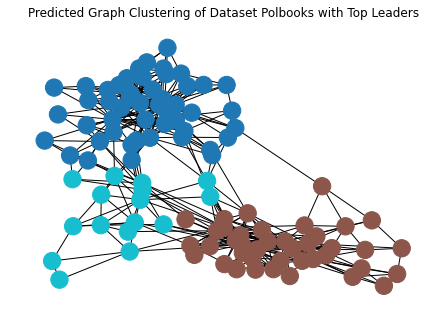

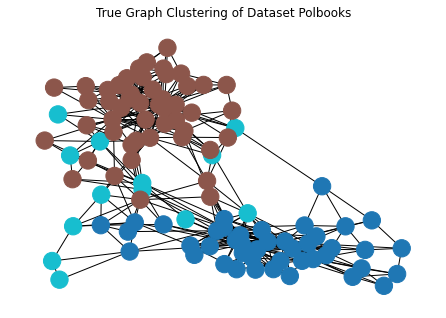

In [147]:
polbooks = GraphClustering(POLBOOKS_DIR)
polbooks.top_leaders(k=3, gamma=2, delta=2)
polbooks.draw_clusters(dataset_name="Polbooks", which='pred')

polbooks.draw_clusters(dataset_name="Polbooks", which='true')